In [4]:
# Basic imports and environment checks
import os
from pathlib import Path
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Create results folder
Path("results/diffusion_notebook_run/samples").mkdir(parents=True, exist_ok=True)
Path("results/diffusion_notebook_run/checkpoints").mkdir(parents=True, exist_ok=True)


PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
# If medmnist not installed in your kernel, uncomment and run this cell once:
# !pip install medmnist
# !pip install diffusers transformers

from medmnist import INFO, PathMNIST, OrganAMNIST


In [6]:
# Configurable arguments
class CFG:
    dataset = "PathMNIST"    # 'PathMNIST' or 'OrganMNIST'
    img_size = 28
    batch_size = 64          # drop to 32/16 if OOM
    epochs = 5
    timesteps = 200          # short for quick demos
    lr = 2e-4
    base_ch = 32
    save_every = 300         # steps
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_dir = Path("results/diffusion_notebook_run")

cfg = CFG()
print(cfg.__dict__)


{}


Saved preview to: results\diffusion_notebook_run\sample_data_preview.png


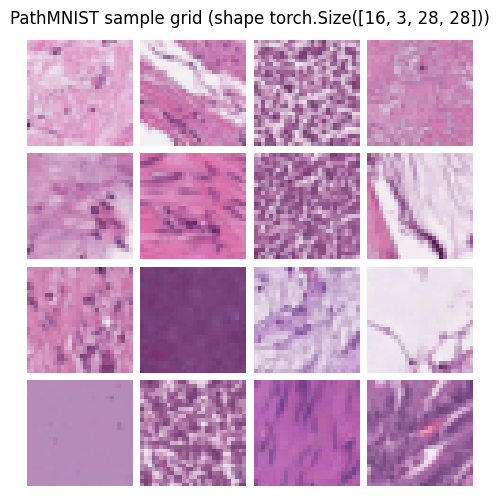

In [9]:
# Load dataset and visualize samples
transform = T.Compose([T.Resize((cfg.img_size, cfg.img_size)), T.ToTensor()])

DataClass = PathMNIST if cfg.dataset == "PathMNIST" else OrganAMNIST
info = INFO[cfg.dataset.lower()]

train_ds = DataClass(split='train', transform=transform, download=True)
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)

# show a grid of samples
imgs, labels = next(iter(train_loader))
imgs = imgs[:16]
# medmnist returns images normalized [0,1]; display
grid = make_grid(imgs, nrow=4, pad_value=1.0)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
plt.title(f"{cfg.dataset} sample grid (shape {imgs.shape})")
plt.axis('off')
# Save preview
save_image(grid, cfg.output_dir / "sample_data_preview.png")
print("Saved preview to:", cfg.output_dir / "sample_data_preview.png")


In [10]:
# Tiny UNet components (same as script)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.AvgPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class TinyUNet(nn.Module):
    def __init__(self, channels=1, base_ch=32):
        super().__init__()
        self.inc = DoubleConv(channels, base_ch)
        self.down1 = Down(base_ch, base_ch*2)
        self.down2 = Down(base_ch*2, base_ch*4)
        self.mid = DoubleConv(base_ch*4, base_ch*4)
        self.up2 = Up(base_ch*4, base_ch*2)
        self.up1 = Up(base_ch*2, base_ch)
        self.outc = nn.Conv2d(base_ch, channels, 1)
    def forward(self, x, t_emb=None):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        xm = self.mid(x3)
        xu = self.up2(xm)
        xu = xu + x2
        xu = self.up1(xu)
        xu = xu + x1
        out = self.outc(xu)
        return out


In [11]:
# Diffusion utilities
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=2e-2):
    return torch.linspace(beta_start, beta_end, timesteps)

class Diffusion:
    def __init__(self, timesteps=1000, device='cpu'):
        self.timesteps = timesteps
        self.device = device
        self.betas = linear_beta_schedule(timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        # gather alpha_hat[t] per-batch
        a_hat = self.alpha_hat[t].view(-1,1,1,1)
        sqrt_a = a_hat.sqrt()
        sqrt_om = (1 - a_hat).sqrt()
        return sqrt_a * x_start + sqrt_om * noise

    def predict_start_from_noise(self, x_t, t, noise):
        a_hat = self.alpha_hat[t].view(-1,1,1,1)
        return (x_t - (1 - a_hat).sqrt() * noise) / a_hat.sqrt()


In [12]:
device = cfg.device
channels = 1 if info['n_channels'] == 1 else 3
model = TinyUNet(channels=channels, base_ch=cfg.base_ch).to(device)
diffusion = Diffusion(timesteps=cfg.timesteps, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

print("Model params:", sum(p.numel() for p in model.parameters())/1e6, "M")


Model params: 0.722499 M


In [13]:
# Training loop (not too long — use cfg.epochs)
step = 0
loss_hist = []
for epoch in range(cfg.epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.epochs}")
    for batch in pbar:
        imgs, labels = batch[0].to(device), batch[1].to(device)
        imgs = imgs.float()
        imgs = imgs * 2. - 1.  # scale to [-1,1]
        bsz = imgs.shape[0]
        t = torch.randint(0, cfg.timesteps, (bsz,), device=device).long()
        noise = torch.randn_like(imgs)
        x_t = diffusion.q_sample(imgs, t, noise=noise)
        pred_noise = model(x_t)
        loss = nn.MSELoss()(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step += 1
        loss_hist.append(float(loss.detach().cpu()))
        pbar.set_postfix(loss=float(loss.detach().cpu()))
        
        # Save sample images and checkpoint periodically
        if step % cfg.save_every == 0:
            model.eval()
            with torch.no_grad():
                n = min(16, imgs.size(0))
                z = torch.randn(n, imgs.size(1), cfg.img_size, cfg.img_size, device=device)
                x = z
                # crude iterative denoise (coarse steps) — fast demo
                steps_to_run = list(range(0, cfg.timesteps, max(1, cfg.timesteps//50)))
                for time_step in reversed(steps_to_run):
                    t_batch = torch.full((n,), time_step, device=device, dtype=torch.long)
                    pred_n = model(x)
                    coef = diffusion.betas[time_step].sqrt()
                    x = (x - coef * pred_n)
                    x = x.clamp(-1,1)
                samples = (x + 1) / 2.0
                grid = make_grid(samples.cpu(), nrow=4, normalize=False)
                save_image(grid, cfg.output_dir / "samples" / f"step_{step}.png")
                # save checkpoint
                torch.save({'model_state': model.state_dict(),
                            'optimizer_state': optimizer.state_dict(),
                            'step': step,
                            'epoch': epoch}, cfg.output_dir / "checkpoints" / f"ckpt_{step}.pt")
                print("Saved sample & checkpoint at step", step)
            model.train()
    # end epoch

print("Training complete. Final step:", step)


Epoch 1/5:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved sample & checkpoint at step 300
Saved sample & checkpoint at step 600
Saved sample & checkpoint at step 900
Saved sample & checkpoint at step 1200


Epoch 2/5:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved sample & checkpoint at step 1500
Saved sample & checkpoint at step 1800
Saved sample & checkpoint at step 2100
Saved sample & checkpoint at step 2400
Saved sample & checkpoint at step 2700


Epoch 3/5:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved sample & checkpoint at step 3000
Saved sample & checkpoint at step 3300
Saved sample & checkpoint at step 3600
Saved sample & checkpoint at step 3900
Saved sample & checkpoint at step 4200


Epoch 4/5:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved sample & checkpoint at step 4500
Saved sample & checkpoint at step 4800
Saved sample & checkpoint at step 5100
Saved sample & checkpoint at step 5400


Epoch 5/5:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved sample & checkpoint at step 5700
Saved sample & checkpoint at step 6000
Saved sample & checkpoint at step 6300
Saved sample & checkpoint at step 6600
Saved sample & checkpoint at step 6900
Training complete. Final step: 7035


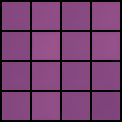

Displayed: results\diffusion_notebook_run\samples\step_6900.png


In [14]:
# Display the last few generated sample images (if any)
samples_dir = cfg.output_dir / "samples"
if samples_dir.exists():
    imgs = sorted(list(samples_dir.glob("*.png")), key=os.path.getmtime)
    if len(imgs) > 0:
        last = imgs[-1]
        from PIL import Image
        display(Image.open(last))
        print("Displayed:", last)
    else:
        print("No sample images found in", samples_dir)
else:
    print("Samples folder not found:", samples_dir)


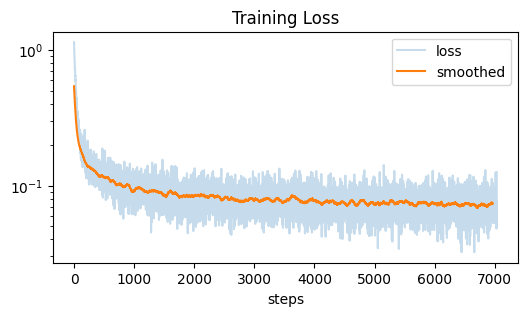

In [15]:
# Plot loss history (smoothed)
import numpy as np
if len(loss_hist) > 0:
    window = max(1, len(loss_hist)//100)
    sm = np.convolve(loss_hist, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(6,3))
    plt.plot(loss_hist, alpha=0.25, label='loss')
    plt.plot(sm, linewidth=1.5, label='smoothed')
    plt.yscale('log')
    plt.title('Training Loss')
    plt.xlabel('steps')
    plt.legend()
    plt.show()
else:
    print("No losses recorded.")
